In [1]:
import os
from concurrent.futures import ProcessPoolExecutor

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from uf3.data import io
from uf3.data import geometry
from uf3.data import composition
from uf3.representation import bspline
from uf3.representation import process
from uf3.regression import least_squares
from uf3.forcefield import calculator
from uf3.forcefield import lammps
from uf3.util import parallel
from uf3.util import plotting

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# $\text{UF}_{2,3}$ Demo: Elemental tungsten

**Data split**
- Training set: 1939 configurations (stratified 20% of the dataset)

- Holdout: 7754 configurations (remaining 80%)

**Inputs**
- ```w-14.xyz``` (30 mb)
- ```training_idx.txt``` (10 kb, included for reproducibility purposes)

**Outputs**
- ```df_features_uf23.h5``` (650 mb)
- ```model_uf23.json``` (3 kb)

In [4]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

 Step         | Estimated Time 
:-------------|:--------------
Preprocessing | 10 seconds
Featurization | 2.5 core-hours (parallelizable)
Training      | 4 seconds
Prediction    | 3 seconds
Plotting      | 10 seconds

# User Parameters

```element_list (list)```: list of element symbols

```degree (int)```: truncation of many-body expansion. A value of 3 yields a two-and-three-body potential.

In [5]:
element_list = ['W']
degree = 3

Initialize the ```ChemicalSystem``` and inspect interactions.

Elements involved in each interactions are sorted by electronegativity.

In [6]:
chemical_system = composition.ChemicalSystem(element_list=element_list,
                                             degree=degree)
print("Pairs:", chemical_system.interactions_map[2])

Pairs: [('W', 'W')]


In [7]:
print("Trios:", chemical_system.interactions_map[3])

Trios: [('W', 'W', 'W')]


```r_min_map (dict)```: map of minimum pair distance per interaction (angstroms). 
    If unspecified, defaults to 1.0 for all interactions.
    
```r_max_map (dict)```: map of maximum pair distance per interaction (angstroms). 
    If unspecified, defaults to 6.0 angstroms for all interactions, which probably encompasses at least 2nd-nearest neighbors.
    
```resolution_map (dict)```: map of resolution (number of knot intervals) per interaction. 
    For the cubic basis, the number of basis functions equals three more than the number of knot intervals.
    This is, in turn, negated by ```trailing_trim```.
    If unspecified, defaults to 20 for all two-body interactions and 5 for three-body interactions.
    
```trailing_trim (int)```: number of trailing basis functions to trim, defaults to 3.
 - ```= 0```: hard cutoff at ```r_max```
 - ```= 1```: function goes to zero at ```r_max```
 - ```= 2```: first derivative goes to zero at ```r_max```
 - ```= 3```: second derivative goes to zero at ```r_max```

**Note: the demo's resolution and cutoffs (3.5-3.5-7.0Å, 5-5-10) are small to reduce runtime and filesize.**

**Results in the manuscript use (4.25-4.25-8.5Å, 10-10-20), requiring about 4 core-hours and 6 gb.**

In [8]:
r_min_map = {("W", "W"): 1.5,
             ("W", "W", "W"): [1.5, 1.5, 1.5],
            }
r_max_map = {("W", "W"): 5.5,
             ("W", "W", "W"): [3.5, 3.5, 7.0],
            }
resolution_map = {("W", "W"): 25,
                  ("W", "W", "W"): [5, 5, 10],
                 }
trailing_trim = 3

# Demo parameters
```n_cores```: number of workers to use in parallel for feature generation

```data_filename```: filename of reference data including geometries, energies, forces, ...

```training_1939```: list of integers corresponding to entries to use for training.

```filename```: filename to save features dataframe.

```table_template```: format string for table names in feature dataframe.

In [9]:
n_cores = 4

In [10]:
example_directory = os.getcwd()
data_filename = os.path.join(example_directory, "w-14.xyz")
with open(os.path.join(example_directory, "training_idx.txt"), "r") as f:
    training_1939 = [int(idx) for idx in f.read().splitlines()]

In [11]:
filename = "df_features_uf23.h5"
table_template = "features_{}"

# Initialize basis

In [12]:
bspline_config = bspline.BSplineBasis(chemical_system,
                                      r_min_map=r_min_map,
                                      r_max_map=r_max_map,
                                      resolution_map=resolution_map,
                                      trailing_trim=trailing_trim)

```bspline_config.get_interaction_partitions()``` yields the number of coefficients for each n-body interaction (one-body terms, two-body terms, three-body terms, ...) as well as the starting index in the coefficient vector for each interaction.

In [13]:
bspline_config.get_interaction_partitions()[0]

{'W': 1, ('W', 'W'): 28, ('W', 'W', 'W'): 144}

In [14]:
bspline_config.get_interaction_partitions()[1]

{'W': 0, ('W', 'W'): 1, ('W', 'W', 'W'): 29}

# Load data

In [15]:
data_coordinator = io.DataCoordinator()
data_coordinator.dataframe_from_trajectory(data_filename,
                                           prefix='dft')
df_data = data_coordinator.consolidate()
print("Number of energies:", len(df_data))
print("Number of forces:", int(np.sum(df_data["size"]) * 3))

Number of energies: 9693
Number of forces: 475578


In [16]:
df_data.head()

,geometry,energy,fx,fy,fz,size
dft_0,"(Atom('W', [0.0, 0.0, 0.0], index=0))",-11.194835,[0.0],[0.0],[0.0],1.0
dft_1,"(Atom('W', [0.0, 0.0, 0.0], index=0))",-11.126991,[0.0],[0.0],[0.0],1.0
dft_2,"(Atom('W', [0.0, 0.0, 0.0], index=0))",-11.133282,[0.0],[0.0],[0.0],1.0
dft_3,"(Atom('W', [0.0, 0.0, 0.0], index=0))",-11.139626,[0.0],[0.0],[0.0],1.0
dft_4,"(Atom('W', [0.0, 0.0, 0.0], index=0))",-11.142003,[0.0],[0.0],[0.0],1.0


# Compute energy and force features



In [18]:
representation = process.BasisFeaturizer(bspline_config)

In [19]:
client = ProcessPoolExecutor(max_workers=n_cores)

In [20]:
representation.batched_to_hdf(filename,
                              df_data,
                              client,
                              n_jobs = n_cores,
                              batch_size=50,
                              progress="bar",
                              table_template=table_template)

100%|██████████| 194/194 [41:12<00:00, 12.74s/it] 


# Fit model

In [21]:
regularizer = bspline_config.get_regularization_matrix(ridge_1b=1e-6,
                                                       curvature_2b=1e-8)

model = least_squares.WeightedLinearModel(bspline_config,
                                          regularizer=regularizer)

# Fit with energies and force

Train with 20% of the dataset (1939 samples)

In [28]:
model.fit_from_file(filename, 
                    # training_1939, 
                    df_data.index,
                    weight=0.5, 
                    batch_size=2500,
                    energy_key="energy", 
                    progress="bar")

100%|██████████| 194/194 [00:06<00:00, 28.77it/s]


In [29]:
solutions = least_squares.arrange_coefficients(model.coefficients, 
                                               bspline_config)

for interaction, values in solutions.items():
    print(interaction, ":", values)

W : -6.909259932419467
('W', 'W') : [ 2.93297225e+01  2.55143795e+01  1.78836962e+01  6.43767510e+00
  2.12571514e+00  3.77982908e-01 -1.33071843e-01 -2.97025328e-01
 -3.22034093e-01 -3.21073654e-01 -3.02947398e-01 -2.42822182e-01
 -2.19312112e-01 -1.89491274e-01 -1.47353861e-01 -9.55381746e-02
 -6.36984459e-02 -4.89182831e-02 -4.67807939e-02 -5.74909235e-02
 -6.66469143e-02 -6.12455261e-02 -3.58659921e-02 -2.06663829e-02
 -8.46676270e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00]
('W', 'W', 'W') : [-1.53070291e+01 -1.38237468e+01 -1.61937573e+01 -6.29792377e+00
  4.15732328e+00 -1.06184740e+00 -1.96704313e+01 -1.29166695e+01
 -2.97025905e+01 -3.04417284e+01  1.47230155e+01 -3.45637820e+00
  5.02864423e+00 -1.06877132e+01 -1.85530698e+01  1.01984203e+01
  2.33019215e+01  6.79577660e+00  1.14012852e+01 -9.64455511e+00
  3.51752365e+01  1.02266826e+01 -1.02238258e+01 -5.76522238e+00
  1.51798681e+01  3.10589091e+01 -5.74296985e+00 -9.85931702e+00
  4.34066085e+01  1.55484193e+01 -5

# Prediction

In [30]:
# predict with remaining 80% of dataset
training_keys = df_data.index[training_1939]
holdout_keys = df_data.index.difference(training_keys)

In [31]:
y_e, p_e, y_f, p_f, rmse_e, rmse_f = model.batched_predict(filename, 
                                                           keys=holdout_keys)

RMSE (energy): 0.012
RMSE (forces): 0.228


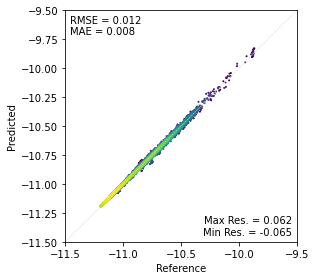

In [32]:
plotting.density_scatter(y_e, p_e)
plt.tight_layout()

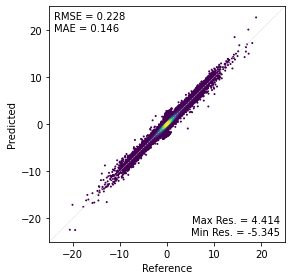

In [33]:
plotting.density_scatter(y_f, p_f)
plt.tight_layout()

# Export potential

In [34]:
model.save("model_uf23.json")

# Compute energy, forces, stress with UFCalculator

In [36]:
calc = calculator.UFCalculator(model)

geom = df_data.iloc[3000]['geometry'].copy()  # 12-atom cell
geom.set_calculator(calc)
print("Energy:", geom.get_potential_energy())
print("Stresses (numerical):", geom.get_stress())
print("Forces:\n", geom.get_forces())
print("Max force:", np.max(np.abs(geom.get_forces())))

Energy: -125.94634737365047
Stresses (numerical): [-0.27284373 -0.21269526 -0.19587426  0.00673861 -0.03251023 -0.06668803]
Forces:
 [[ 0.9247198   7.1954469  -0.51517995]
 [-3.09391715  0.34519563  0.45007935]
 [ 3.60074214  1.16019415  0.47379295]
 [ 4.3535802  -4.65271381  0.62942499]
 [-1.80424397 -2.67622904 -1.71355421]
 [-1.70798109  3.64077167  1.33918404]
 [-2.27916515 -3.19984066  1.08843362]
 [ 2.23753848  1.25635827 -1.37486839]
 [ 1.95888195 -0.86112301 -0.01602678]
 [-1.66730536 -6.8770263   0.13213979]
 [-4.3160293   3.18834981 -0.11026939]
 [ 1.79317945  1.48061639 -0.38315601]]
Max force: 7.195446900679501
